# Applying Classification

In this chapter we'll look at a few examples of applying classification.  We'll start by looking at A/B testing like we did for applying hypothesis testing.  Then we'll move onto an example with customer churn.  We'll end the chapter with an example of credit card fraud.  

## A/B Testing

Recall from the Applying Statistical Tests chapter we want to send an email about a towel sale.  We will have both a control and test group - one in which something about the email changed (test) and one in which the email stays the same as in the past (control).  We will use these two samples to set up an experiment.  Did changing the email effect things?

Last time we answered this question with hypothesis testing.  Now we will answer it with a classifier!

### Recall Set Up

In order to test this question, we can set up an experiment.  Here we will set up a randomized test group and a randomized control group.  

The test group will be sent an email, with slightly different copy, or possibly with a picture.  Some specific change will be made, in any event.

The control group will get the same email as last time.  This way, we can directly compare, as much as possible between the old email and the new one.  There are many things you typically need to control for, or account for in experimental design.  Some things to account for in this scenario are:

1) Age

2) Gender

3) Location

4) Time of Day

5) Time of Year

6) Approximate Disposable Income


## Simulating Some Data

In [41]:
import warnings
warnings.filterwarnings('ignore')

In [157]:
import random
import pandas as pd
import numpy as np

def generate_data(df, column, choices, size):
    """
    Generates categorical data given choices.
    
    Parameters:
    * df - pd.DataFrame: the data to add a column to
    * column - str: the column to generate
    * choices - list: the list of possible choices
    
    Returns:
    A dataframe with the newly generated column.
    """
    df[column] = [random.choice(choices)
                  for _ in range(size)]
    df = pd.concat([df, pd.get_dummies(df[column])], axis=1)
    df = df.drop(column, axis=1)
    return df

def converted_score(x):
    if x["male"] == 1:
        gender = 0.7
    elif x["female"] == 1:
        gender = 1.4
    if x["white"] == 1:
        race = 0.5
    elif x["black"] == 1:
        race = 1.4
    elif x["asian"] == 1:
        race = 2.8
    elif x["hispanic"] == 1:
        race = 3.7
    salary_alpha = gender * race
    age_alpha = gender + race
    return salary_alpha * x["salary"] + age_alpha * x["age"]

def decision_boundary(result):
    if result > 250000:
        return 1
    else:
        return 0
    
size = 5000
test_df = pd.DataFrame()
control_df = pd.DataFrame()
gender_choices = ["male", "female"]
race_choices = ["white", "black", "asian", "hispanic"]
test_salary_mean = 150000
test_salary_variance = 30000 
control_salary_mean = 55000
control_salary_variance = 2000

test_df = generate_data(test_df, "gender", gender_choices, size)
test_df = generate_data(test_df, "race", race_choices, size)
test_df["age"] = np.random.normal(50, 25, size=len(test_df))
test_df["age"] = test_df["age"].astype(int)
test_df["salary"] = np.random.normal(test_salary_mean, 
                                     test_salary_variance, 
                                     size=len(test_df))
test_df["salary"] = test_df["salary"].apply(lambda x: round(x, 2))

test_df["converted"] = test_df.apply(converted_score, axis=1)
test_df["converted"] = test_df["converted"].apply(decision_boundary)

control_df = generate_data(control_df, "gender", gender_choices, size)
control_df = generate_data(control_df, "race", race_choices, size)
control_df["age"] = np.random.normal(50, 25, size=len(control_df))
control_df["age"] = control_df["age"].astype(int)
control_df["salary"] = np.random.normal(control_salary_mean, 
                                        control_salary_variance, 
                                        size=len(control_df))
control_df["salary"] = control_df["salary"].apply(lambda x: round(x, 2))
control_df["converted"] = control_df.apply(converted_score, axis=1)
control_df["converted"] = control_df["converted"].apply(decision_boundary)

print(test_df["converted"].value_counts())
print(control_df["converted"].value_counts())

1    2787
0    2213
Name: converted, dtype: int64
0    4418
1     582
Name: converted, dtype: int64


Here's where things get different! The next step is now to model our test and control and see if the probability of conversion is higher or lower for our test and control sets.  If they are the same or similar then our change likely had little effect.  Of course you should verify this with multiple tests as well as cross validation if possible.

              precision    recall  f1-score   support

           0       1.00      0.94      0.97       528
           1       0.96      1.00      0.98       722

    accuracy                           0.97      1250
   macro avg       0.98      0.97      0.97      1250
weighted avg       0.97      0.97      0.97      1250

ROC AUC 0.9692588978426929


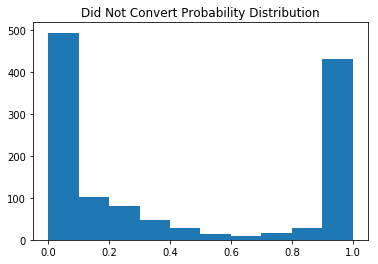

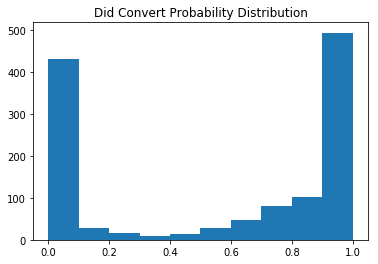

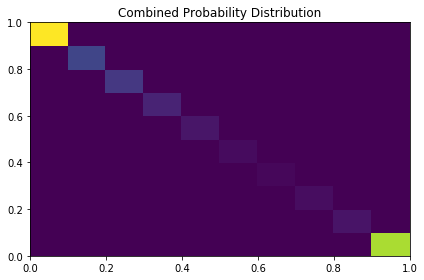

In [180]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

augmented_df = test_df.copy()
augmented_y = augmented_df["converted"]
cols = augmented_df.columns.tolist()
cols.remove("converted")
augmented_X = augmented_df[cols]

X_train, X_test, y_train, y_test = train_test_split(
    augmented_X, augmented_y
)
clf = LogisticRegression(
    max_iter=1000, class_weight="balanced", 
    C=100, penalty="l2", solver="liblinear"
)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))
print("ROC AUC", roc_auc_score(y_test, y_pred))
plt.hist(clf.predict_proba(X_test).T[0])
plt.title('Did Not Convert Probability Distribution')
plt.show()
plt.hist(clf.predict_proba(X_test).T[1])
plt.title('Did Convert Probability Distribution')
plt.show()
ig, ax = plt.subplots(tight_layout=True)
hist = ax.hist2d(clf.predict_proba(X_test).T[0], clf.predict_proba(X_test).T[1])
plt.title('Combined Probability Distribution')
plt.show()

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1096
           1       1.00      1.00      1.00       154

    accuracy                           1.00      1250
   macro avg       1.00      1.00      1.00      1250
weighted avg       1.00      1.00      1.00      1250

ROC AUC 1.0


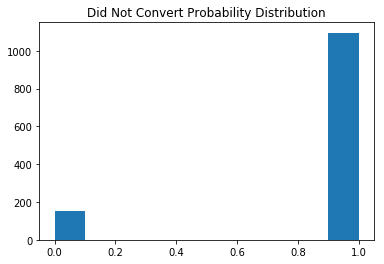

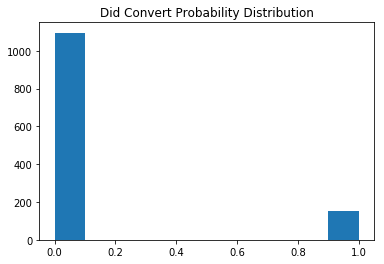

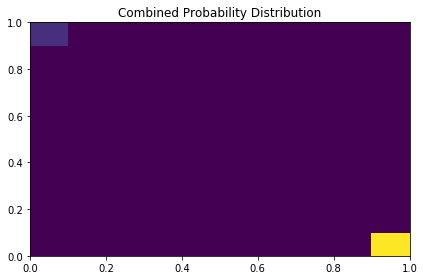

In [181]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

control_y = control_df["converted"]
cols = control_df.columns.tolist()
cols.remove("converted")
control_X = control_df[cols]

X_train, X_test, y_train, y_test = train_test_split(
    control_X, control_y
)
clf = LogisticRegression(
    max_iter=1000, class_weight="balanced", 
    C=100, penalty="l2", solver="liblinear"
)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))
print("ROC AUC", roc_auc_score(y_test, y_pred))
plt.hist(clf.predict_proba(X_test).T[0])
plt.title('Did Not Convert Probability Distribution')
plt.show()
plt.hist(clf.predict_proba(X_test).T[1])
plt.title('Did Convert Probability Distribution')
plt.show()
ig, ax = plt.subplots(tight_layout=True)
hist = ax.hist2d(clf.predict_proba(X_test).T[0], clf.predict_proba(X_test).T[1])
plt.title('Combined Probability Distribution')
plt.show()